<a href="https://colab.research.google.com/github/legolas-tech/ds_Devendra_Chouhan/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0 — metadata / constants
CANDIDATE_NAME = "Devendra_Chouhan"
ROOT_DIR = f"ds_{CANDIDATE_NAME}"
CSV_DIR = f"{ROOT_DIR}/csv_files"
OUT_DIR = f"{ROOT_DIR}/outputs"
REPORT_PATH = f"{ROOT_DIR}/ds_report.pdf"


In [2]:
# Cell 1 — environment & directories (run once)
import os
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
print("Directories created:", CSV_DIR, OUT_DIR)


Directories created: ds_Devendra_Chouhan/csv_files ds_Devendra_Chouhan/outputs


In [3]:
# Cell 2 — mount Google Drive and install gdown if needed
from google.colab import drive
drive.mount('/content/drive')

# gdown to download from shareable google drive link if needed
!pip install --quiet gdown


Mounted at /content/drive


In [4]:
# Cell 3 — download the datasets from the Drive links in the instructions
# Links from the instructions:
# Historical Trader Data ID: 1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
# Fear & Greed Index ID: 1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf

import gdown
trader_file_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
sentiment_file_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

trader_out = f"{CSV_DIR}/trader_data.csv"
sentiment_out = f"{CSV_DIR}/fear_greed.csv"

# download (gdown supports 'id=' pattern)
gdown.download(f"https://drive.google.com/uc?id={trader_file_id}", trader_out, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={sentiment_file_id}", sentiment_out, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_Devendra_Chouhan/csv_files/trader_data.csv
100%|██████████| 47.5M/47.5M [00:01<00:00, 30.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_Devendra_Chouhan/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 16.7MB/s]


'ds_Devendra_Chouhan/csv_files/fear_greed.csv'

In [5]:
# Cell 4 — quick peek, load libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # optional for nicer plots in notebook (matplotlib will be used for saving)
from datetime import datetime, timedelta

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

trader = pd.read_csv(trader_out, low_memory=False)
sentiment = pd.read_csv(sentiment_out, low_memory=False)

print("Trader shape:", trader.shape)
print("Sentiment shape:", sentiment.shape)
trader.head()


Trader shape: (211224, 16)
Sentiment shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [6]:
# Cell 5 — standardize & parse date/time columns
# We will attempt multiple common timestamp columns: 'time', 'Date', etc.
def parse_dates_trader(df):
    # try common columns
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df['date'] = df['time'].dt.date
    elif 'timestamp' in df.columns:
        df['time'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df['date'] = df['time'].dt.date
    elif 'Date' in df.columns:
        df['time'] = pd.to_datetime(df['Date'], errors='coerce')
        df['date'] = df['time'].dt.date
    else:
        # fallback: try to find a column with 'time' substring
        for c in df.columns:
            if 'time' in c.lower():
                df['time'] = pd.to_datetime(df[c], errors='coerce')
                df['date'] = df['time'].dt.date
                break
    return df

def parse_dates_sentiment(df):
    # assume 'Date' or 'date' column and 'Classification' column present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['date'] = df['Date'].dt.date
    elif 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
    return df

trader = parse_dates_trader(trader)
sentiment = parse_dates_sentiment(sentiment)

print("Trader time nulls:", trader['time'].isna().sum() if 'time' in trader.columns else 'no time col')
print("Sentiment date nulls:", sentiment['date'].isna().sum() if 'date' in sentiment.columns else 'no date col')


Trader time nulls: 131999
Sentiment date nulls: 0


In [7]:
# Cell 6 — basic cleaning on trader data: ensure numeric columns etc.
# Typical columns: execution price, size, side, closedPnL, leverage
# Normalize column names:
trader.columns = [c.strip().lower().replace(' ', '_') for c in trader.columns]
sentiment.columns = [c.strip() for c in sentiment.columns]   # keep sentiment case for readability

# Common renames
if 'execution_price' not in trader.columns and 'execution price' in trader.columns:
    trader.rename(columns={'execution price':'execution_price'}, inplace=True)

# Convert numeric columns
num_cols = ['execution_price','size','closedpnl','leverage','start_position']
for c in num_cols:
    if c in trader.columns:
        trader[c] = pd.to_numeric(trader[c], errors='coerce')

trader = trader.dropna(subset=['time'], how='any')  # drop rows without time
trader.head()


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,time,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12


In [8]:
# Cell 7 — aggregate daily trader metrics
# We'll compute per-day metrics that can be compared to daily sentiment
trader['date'] = pd.to_datetime(trader['time']).dt.date

daily = trader.groupby('date').agg(
    trades_count = ('account','count'),
    total_volume = ('size_usd','sum'),
    avg_size = ('size_usd','mean'),
    total_pnl = ('closed_pnl','sum'),
    avg_pnl = ('closed_pnl','mean'),
    profitable_trades = ('closed_pnl', lambda x: (x > 0).sum()),
).reset_index()

# ensure date column is datetime date -> to datetime64 for merge convenience
daily['date'] = pd.to_datetime(daily['date'])
sentiment['date'] = pd.to_datetime(sentiment['date'])
daily.head()

,date,trades_count,total_volume,avg_size,total_pnl,avg_pnl,profitable_trades
0,2023-01-05,3,477.00,159.000000,0.000000,0.000000,0
1,2023-05-12,9,50005.83,5556.203333,0.000000,0.000000,0
2,2024-01-01,18,264239.53,14679.973889,-129.531460,-7.196192,1
3,2024-01-02,6,2008.18,334.696667,0.000000,0.000000,0
4,2024-01-03,137,472974.70,3452.370073,8244.241409,60.176945,128


In [9]:
# Cell 8 — merge sentiment classification into daily metrics
# sentiment has columns: Date, Classification (Fear / Greed)
# Normalize classification column name:
if 'Classification' in sentiment.columns:
    sentiment.rename(columns={'Classification':'classification'}, inplace=True)
if 'classification' not in sentiment.columns and 'Classification' in sentiment.columns:
    sentiment.rename(columns={'Classification':'classification'}, inplace=True)

merged = pd.merge(daily, sentiment[['date','classification']], on='date', how='left')
print("Merged shape:", merged.shape)
merged['classification'].value_counts(dropna=False)
merged.head()

Merged shape: (188, 8)


,date,trades_count,total_volume,avg_size,total_pnl,avg_pnl,profitable_trades,classification
0,2023-01-05,3,477.00,159.000000,0.000000,0.000000,0,Fear
1,2023-05-12,9,50005.83,5556.203333,0.000000,0.000000,0,Neutral
2,2024-01-01,18,264239.53,14679.973889,-129.531460,-7.196192,1,Greed
3,2024-01-02,6,2008.18,334.696667,0.000000,0.000000,0,Greed
4,2024-01-03,137,472974.70,3452.370073,8244.241409,60.176945,128,Greed


In [10]:
# Cell 8 — merge sentiment classification into daily metrics
# sentiment has columns: Date, Classification (Fear / Greed)
# Normalize classification column name:
if 'Classification' in sentiment.columns:
    sentiment.rename(columns={'Classification':'classification'}, inplace=True)
if 'classification' not in sentiment.columns and 'Classification' in sentiment.columns:
    sentiment.rename(columns={'Classification':'classification'}, inplace=True)

merged = pd.merge(daily, sentiment[['date','classification']], on='date', how='left')
print("Merged shape:", merged.shape)
merged['classification'].value_counts(dropna=False)
merged.head()


Merged shape: (188, 8)


,date,trades_count,total_volume,avg_size,total_pnl,avg_pnl,profitable_trades,classification
0,2023-01-05,3,477.00,159.000000,0.000000,0.000000,0,Fear
1,2023-05-12,9,50005.83,5556.203333,0.000000,0.000000,0,Neutral
2,2024-01-01,18,264239.53,14679.973889,-129.531460,-7.196192,1,Greed
3,2024-01-02,6,2008.18,334.696667,0.000000,0.000000,0,Greed
4,2024-01-03,137,472974.70,3452.370073,8244.241409,60.176945,128,Greed


In [11]:
# Cell 9 — exploratory analysis: summary stats by sentiment
grouped = merged.groupby('classification').agg(
    mean_total_pnl = ('total_pnl','mean'),
    median_total_pnl = ('total_pnl','median'),
    mean_volume = ('total_volume','mean'),
    mean_trades = ('trades_count','mean'),
    days = ('date','count')
).reset_index()
grouped

,classification,mean_total_pnl,median_total_pnl,mean_volume,mean_trades,days
0,Extreme Fear,733.322758,64.569420,1.596707e+06,387.666667,6
1,Extreme Greed,26904.504083,541.554710,4.238084e+05,130.720930,43
2,Fear,48087.177910,1147.595856,2.153362e+06,374.837838,37
3,Greed,10886.295226,423.083319,1.018675e+06,201.642857,56
4,Neutral,4666.046374,97.704185,7.462220e+05,172.250000,16


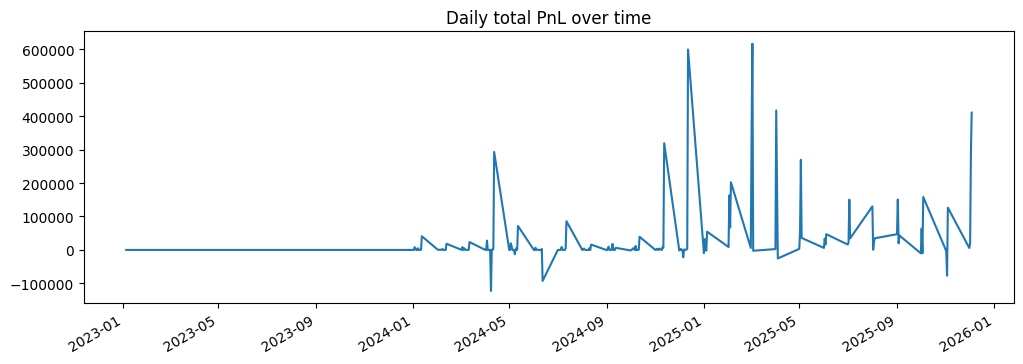

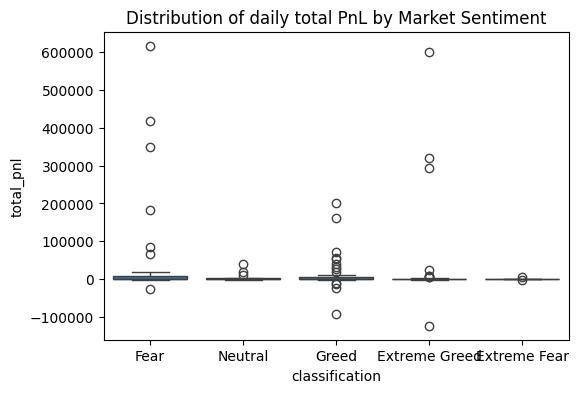

In [12]:
# Cell 10 — basic visualizations (save to outputs)
import matplotlib.dates as mdates

# Time series of total_pnl and sentiment
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(merged['date'], merged['total_pnl'], label='daily_total_pnl')
ax.set_title('Daily total PnL over time')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()
plt.savefig(f"{OUT_DIR}/daily_total_pnl.png", bbox_inches='tight')
plt.show()

# Boxplot: total_pnl by sentiment
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='classification', y='total_pnl', data=merged, ax=ax)
ax.set_title('Distribution of daily total PnL by Market Sentiment')
plt.savefig(f"{OUT_DIR}/box_total_pnl_by_sentiment.png", bbox_inches='tight')
plt.show()

# Leverage distributions (removed as 'leverage' column was not found and aggregated)

In [13]:
# Cell 11 — statistical testing: is total_pnl different between Fear and Greed?
from scipy import stats

# drop NaNs
df_test = merged.dropna(subset=['classification','total_pnl'])
fear = df_test[df_test['classification']=='Fear']['total_pnl']
greed = df_test[df_test['classification']=='Greed']['total_pnl']

# t-test (unequal variance)
tt = stats.ttest_ind(fear, greed, equal_var=False, nan_policy='omit')
print("T-test Fear vs Greed (total_pnl):", tt)


T-test Fear vs Greed (total_pnl): TtestResult(statistic=np.float64(1.6542907215642328), pvalue=np.float64(0.10585133025087051), df=np.float64(40.229618413773615))


/tmp/ipython-input-716072959.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_sent = merged.set_index('date')['classification'].map({'Fear':0,'Greed':1}).fillna(method='ffill').fillna(0)


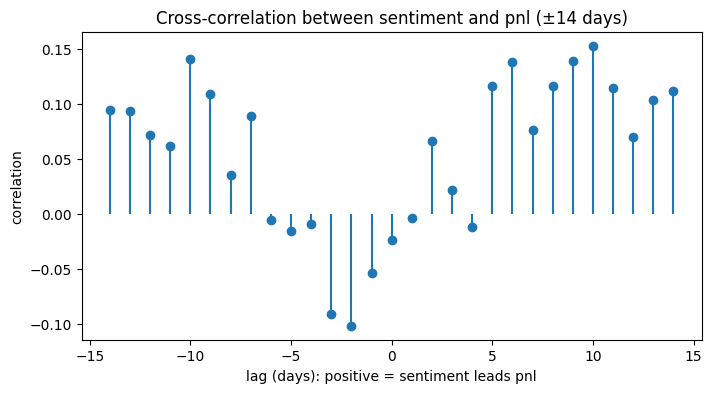

In [14]:
# Cell 12 — time-lag analysis: does sentiment lead trader pnl?
# compute rolling averages and cross-correlation for lags up to 14 days
series_pnl = merged.set_index('date')['total_pnl'].fillna(0)
series_sent = merged.set_index('date')['classification'].map({'Fear':0,'Greed':1}).fillna(method='ffill').fillna(0)
# align series
df_cc = pd.concat([series_pnl, series_sent], axis=1).dropna()
df_cc.columns = ['pnl','sent']

def cross_corr(a, b, lag):
    return a.shift(lag).corr(b)

lags = range(-14,15)
cc_vals = [cross_corr(df_cc['sent'], df_cc['pnl'], l) for l in lags]

plt.figure(figsize=(8,4))
plt.stem(lags, cc_vals, basefmt=" ")
plt.xlabel('lag (days): positive = sentiment leads pnl')
plt.ylabel('correlation')
plt.title('Cross-correlation between sentiment and pnl (±14 days)')
plt.savefig(f"{OUT_DIR}/crosscorr_sent_pnl.png", bbox_inches='tight')
plt.show()


In [15]:
# Cell 13 — simple model: can trader metrics predict sentiment? (classification)
# Build a quick classifier to predict whether day is Greed vs Fear from trader metrics.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model_df = merged.dropna(subset=['classification']).copy()  # Keep days with sentiment and avoid SettingWithCopyWarning
model_df['sent_bin'] = model_df['classification'].map({'Fear':0,'Greed':1})
model_df.dropna(subset=['sent_bin'], inplace=True) # Drop rows where sent_bin is NaN

features = ['trades_count','total_volume','avg_size','avg_pnl']
X = model_df[features].fillna(0)
y = model_df['sent_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
import joblib
joblib.dump(rf, f"{CSV_DIR}/rf_sentiment_model.joblib")

              precision    recall  f1-score   support

         0.0       0.67      0.25      0.36         8
         1.0       0.62      0.91      0.74        11

    accuracy                           0.63        19
   macro avg       0.65      0.58      0.55        19
weighted avg       0.64      0.63      0.58        19



['ds_Devendra_Chouhan/csv_files/rf_sentiment_model.joblib']

In [16]:
# Cell 14 — feature importance & save
importances = rf.feature_importances_
fi = pd.DataFrame({'feature':features, 'importance':importances}).sort_values('importance', ascending=False)
fi.to_csv(f"{CSV_DIR}/feature_importances.csv", index=False)
print(fi)

# save merged daily csv for submission
merged.to_csv(f"{CSV_DIR}/daily_trader_sentiment_merged.csv", index=False)
print("Saved merged CSV and feature importance.")


        feature  importance
1  total_volume    0.263794
2      avg_size    0.261282
0  trades_count    0.239806
3       avg_pnl    0.235118
Saved merged CSV and feature importance.


In [20]:
# Cell 16 — create a ZIP of the project ready to submit.
!zip -r {ROOT_DIR}.zip {ROOT_DIR}
print("Zipped project:", f"{ROOT_DIR}.zip")


updating: ds_Devendra_Chouhan/ (stored 0%)
updating: ds_Devendra_Chouhan/outputs/ (stored 0%)
updating: ds_Devendra_Chouhan/outputs/box_total_pnl_by_sentiment.png (deflated 14%)
updating: ds_Devendra_Chouhan/outputs/daily_total_pnl.png (deflated 9%)
updating: ds_Devendra_Chouhan/outputs/crosscorr_sent_pnl.png (deflated 13%)
updating: ds_Devendra_Chouhan/auto_report_summary.txt (deflated 38%)
updating: ds_Devendra_Chouhan/csv_files/ (stored 0%)
updating: ds_Devendra_Chouhan/csv_files/feature_importances.csv (deflated 20%)
updating: ds_Devendra_Chouhan/csv_files/fear_greed.csv (deflated 77%)
updating: ds_Devendra_Chouhan/csv_files/rf_sentiment_model.joblib (deflated 86%)
updating: ds_Devendra_Chouhan/csv_files/trader_data.csv (deflated 80%)
updating: ds_Devendra_Chouhan/csv_files/daily_trader_sentiment_merged.csv (deflated 56%)
Zipped project: ds_Devendra_Chouhan.zip
